## Import des packages


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [ ]:
!pip install spacy
!pip install nltk
!pip install emot
!pip install scattertext

In [ ]:
!python -m spacy download fr_core_news_md

In [ ]:
# Modules de traitement du texte
import spacy
import fr_core_news_md
import nltk
import re
from termcolor import colored
from emot.emo_unicode import UNICODE_EMO, EMOTICONS


In [ ]:
# Modules pour le wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# Modules de modélisation
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix,classification_report


# Module pour scattertext
import scattertext as st


## Import des données



In [ ]:
# Import des données

df = pd.read_csv("tweets.csv")
df.head()

,id,created_at,favorite_count,retweet_count,text,user_id
0,1355788407344164865,2021-01-31 08:02:00,628,223,Il faut imaginer une autre façon de vivre. #OE...,JLMelenchon
1,1355687094627274760,2021-01-31 01:19:25,541,213,Ils ont transformé le Bac en marchandise. Et v...,JLMelenchon
2,1355683811976237057,2021-01-31 01:06:22,434,169,La Commune appartient à l'histoire de France. ...,JLMelenchon
3,1355680607657996288,2021-01-31 00:53:38,363,139,"Ce qui compte c'est les idées, et plus exactem...",JLMelenchon
4,1355679024404713474,2021-01-31 00:47:21,479,189,La situation des étudiants était prévisible. A...,JLMelenchon


## **1. Analyse descriptive**



In [ ]:
# Parcours des données
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7690 entries, 0 to 7689
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              7690 non-null   int64 
 1   created_at      7690 non-null   object
 2   favorite_count  7690 non-null   int64 
 3   retweet_count   7690 non-null   int64 
 4   text            7690 non-null   object
 5   user_id         7690 non-null   object
dtypes: int64(3), object(3)
memory usage: 360.6+ KB


In [ ]:
#Nombre de lignes et colonnes
df.shape

(7690, 6)

In [ ]:
# Données manquantes ?
"""Avec .info(), on peut savoir le nombre de données non-nulles"""
"""ou avec la méthode .isnull().sum()"""

def missing_data():
  print(df.isnull().sum())

missing_data()

id                0
created_at        0
favorite_count    0
retweet_count     0
text              0
user_id           0
dtype: int64


In [ ]:
#Combien de tweets de JLM et MLP ?
print(df.user_id.value_counts())
print()
print("En pourcentage :")
print(df.user_id.value_counts()/len(df)) #ou df.user_id.value_counts(normalize=True)
print()
""" Ici on sait que notre échantillon est assez équilibré """

EmmanuelMacron    2897
MLP_officiel      2559
JLMelenchon       2234
Name: user_id, dtype: int64

En pourcentage :
EmmanuelMacron    0.376723
MLP_officiel      0.332770
JLMelenchon       0.290507
Name: user_id, dtype: float64



' Ici on sait que notre échantillon est assez équilibré '

In [ ]:
# Dates minimales et maximales de chaque tweet 

#min = df.groupby(["user_id"]).created_at.min()
#max = df.groupby(["user_id"]).created_at.max()

df.groupby(["user_id"]).created_at.apply(lambda x : [x.min(), x.max()])


user_id
EmmanuelMacron    [2018-05-01 18:40:31, 2021-01-30 17:08:01]
JLMelenchon       [2020-04-19 09:59:47, 2021-01-31 08:02:00]
MLP_officiel      [2019-01-19 16:05:02, 2021-01-29 21:02:28]
Name: created_at, dtype: object

In [ ]:
# Quelle est la distribution des favoris et des retweets ?
"""" c'est-à-dire regarder la médiane, moyenne, quartiles... """

df.groupby(["user_id"])[["favorite_count", "retweet_count"]].describe()

favorite_count                             ... retweet_count                
                        count         mean           std  ...           50%    75%      max
user_id                                                   ...                              
EmmanuelMacron         2897.0  5506.235416  13867.602674  ...         448.0  908.0  71405.0
JLMelenchon            2234.0   742.933751   2288.676408  ...          93.0  299.0  27751.0
MLP_officiel           2559.0  1172.197733   1168.385382  ...         341.0  626.0   4219.0

[3 rows x 16 columns]

In [ ]:
# Répartition du nombre de tweets et de favoris dans le temps

import datetime 

df["created_at"] = pd.to_datetime(df['created_at'])
""" Permet de changer le format des dates pour pouvoir l'afficher sur le graphique """

def visualize_count_favorites(df, userID) : 
  
  ''' Cette fonction permet de visualiser le nombre de favoris et de retweets 
  sur toute la période pour un user_id donné '''

  df_temp = df.loc[df["user_id"] == userID]
  ylabels = ["favorite_count", "retweet_count"]

  print("Représentation des nombres de retweets et de favoris de chaque tweet de {} par date".format(userID))
  fig = plt.figure(figsize=(13,3))
  fig.subplots_adjust(hspace=0.01,wspace=0.01)

  n_row = len(ylabels)
  n_col = 1
  for count, ylabel in enumerate(ylabels):
      ax = fig.add_subplot(n_row, n_col, count + 1)
      ax.plot(df_temp["created_at"], df_temp[ylabel])
      ax.set_ylabel(ylabel)
  
  plt.show()

Représentation des nombres de retweets et de favoris de chaque tweet de JLMelenchon par date


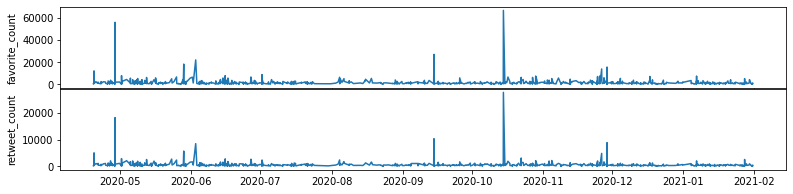



Représentation des nombres de retweets et de favoris de chaque tweet de MLP_officiel par date


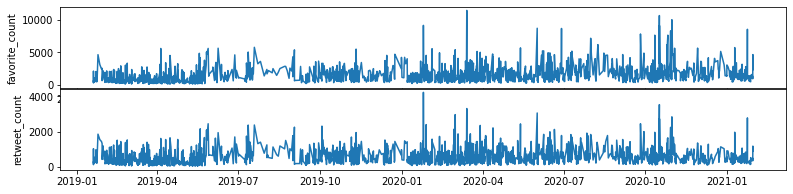

In [ ]:
visualize_count_favorites(df, "JLMelenchon")
print("\n")
visualize_count_favorites(df, "MLP_officiel")

In [ ]:
df.head()

,id,created_at,favorite_count,retweet_count,text,user_id
0,1355788407344164865,2021-01-31 08:02:00,628,223,Il faut imaginer une autre façon de vivre. #OE...,JLMelenchon
1,1355687094627274760,2021-01-31 01:19:25,541,213,Ils ont transformé le Bac en marchandise. Et v...,JLMelenchon
2,1355683811976237057,2021-01-31 01:06:22,434,169,La Commune appartient à l'histoire de France. ...,JLMelenchon
3,1355680607657996288,2021-01-31 00:53:38,363,139,"Ce qui compte c'est les idées, et plus exactem...",JLMelenchon
4,1355679024404713474,2021-01-31 00:47:21,479,189,La situation des étudiants était prévisible. A...,JLMelenchon


In [ ]:
# Tailles des tweets par politique

df["length_text"] = df["text"].apply(lambda x : len(x.split()))
df.head()

df.groupby(["user_id"]).length_text.apply(lambda x: [f"min={x.min()} : max={x.max()}"])

df.groupby(["user_id"]).length_text.describe()



,count,mean,std,min,25%,50%,75%,max
user_id,,,,,,,,
EmmanuelMacron,2897.0,28.575423,12.003363,1.0,19.0,29.0,39.0,57.0
JLMelenchon,2234.0,30.417189,11.141463,1.0,22.0,31.0,39.0,58.0
MLP_officiel,2559.0,35.613130,10.775029,1.0,30.0,38.0,43.0,55.0


In [ ]:
def print_famous_tweets(userID, nb_favorites) :

  ''' Cette fonction permet de sélectionner les tweets qui ont eu le plus de favoris 
  pour un user_id donné, et de lire le tweet avec les indicateurs des autres variables de la 
  base de données  
  '''

  df_sub = df.loc[(df.user_id==userID) & (df.favorite_count > nb_favorites),:]
  for irow in range(df_sub.shape[0]):
      df_row = df_sub.iloc[irow,:]
    
      print(df_row["created_at"])
      print("favorite_count={:6} retweet_count={:6}".format(df_row["favorite_count"],df_row["retweet_count"]))
      print(colored(df_row["text"], 'cyan'))
      print("\n")

print_famous_tweets("JLMelenchon", 20000)
print("-" * 150)
print_famous_tweets("MLP_officiel", 10000)

2020-10-14 18:38:21
favorite_count= 66651 retweet_count= 27751
60 % des contaminations ont lieu au travail ou à l'école ou à l'université entre 8h et 19h. 

Mais #Macron interdit les sorties au bar et au restau entre 20h et 6h. 

Bienvenue en Absurdie.

#macron20h #CouvreFeu #COVID19france


2020-09-14 13:41:47
favorite_count= 26941 retweet_count= 10319
La haine contre la 2ème religion du pays n'a donc plus de limite. https://t.co/0latKIG78G


2020-06-02 21:42:01
favorite_count= 21947 retweet_count=  8461
#Castaner ! La violence c'est vous et votre préfet qui la provoquez ! Ça suffit ! Le pays mérite mieux que votre jeu d'apprenti sorcier. Donald Trump n'est pas un modèle. #JusticePourAdama


2020-04-28 19:56:04
favorite_count= 55881 retweet_count= 18265
J'ai pas compris. Le #11mai il déconfine les coiffeurs oui ou non ? #DirectAN https://t.co/3s2ml69ful https://t.co/XWTCpZr4j5


-----------------------------------------------------------------------------------------------------------

## **2. Preprocessing du texte**


### Nettoyage du texte
Retrait des mots qui rajoutent du bruit à l'analyse (et n'apportent rien) \
- convertion des emojis en texte
- suppression de certaines expressions grâce à des expressions régulières
- suppression des stopwords


In [ ]:
# on charge le modèle français de spacy
nlp = fr_core_news_md.load()

In [ ]:
from spacy.lang.fr.stop_words import STOP_WORDS as stopwords

In [ ]:
# On rajoute dans des stopwords à la liste de stopwords proposée par spacy
stopwords |= {"mlp","a","faut","faire","monsieur","rendez-vous","direct",
                            "interview",r"invité\w+","dit","livetweet","suivez","celui",
                            "ce","cette","emot_right_arrow"}

len(stopwords)

611

In [ ]:
# Conversion des emojis en texte

def convert_emojis(text):
  ''' Cette fonction transforme les emojis en texte qui commente par 
  emot_ puis la description en anglais de l'emoji.
  Certains emojis ne sont pas bien convertis (ex : certains drapeaux)'''

  for emot in UNICODE_EMO:
    name_emoticon = "_".join(UNICODE_EMO[emot].replace(",","").replace(":","").replace("&","").split())
    name_emoticon = re.sub(r"[_-]+", "_", name_emoticon)
    name_emoticon = "emot_" + name_emoticon + " "
    text = text.replace(emot, name_emoticon + " ")
  text = re.sub(r"\s+", " ", text)
  return text


In [ ]:
regexp_link = re.compile(r"http\S+") # suppression des liens
regexp_punctuation = re.compile("[,\./<>\?;':\"\[\]\\{}|`~!$%^&*()+-=«»’]") # suppression des ponctuations
regexp_hashtags = re.compile(r"[#@]\w+")    # suppression des hashtags et @

# Rajout regexp après premier scattertext
regexp_frenchflag = re.compile("🇫🇷")

In [ ]:
df["text"] = [x.lower() for x in df["text"]]

def remove_punct(doc):
  return [token for token in doc if not token.is_punct]

def remove_stop_words(doc):
  return [token for token in doc if not token.is_stop]

def lemmatize(doc):
   return ' '.join([token.lemma_ for token in doc])

In [ ]:
'''Fonction permettant de nettoyer le texte. Elle reprend les fonctions ci-dessus pour retirer les ponctuations, les hashtags et les liens'''

def preprocess_tweet(text, lemmatizing=True, delete_pos=False) : 
  
  emojis_converted = convert_emojis(text)
  french_flag_added = re.sub(regexp_frenchflag, "french_flag", emojis_converted)
  text_to_lower = french_flag_added.lower().encode('utf-8').decode('utf-8')
  text_no_link = re.sub(regexp_link, "", text_to_lower)
  text_no_hastags = re.sub(regexp_hashtags, "", text_no_link)
  
  # utilisation de spacy
  doc = nlp(text_no_hastags)
  removed_punct = remove_punct(doc)
  preprocessed_tweet = remove_stop_words(removed_punct)
  if lemmatizing :
    preprocessed_tweet = lemmatize(preprocessed_tweet)
    
  return(preprocessed_tweet)

In [ ]:
# Création d'une nouvelle colonne avec les données nettoyées 
df["preprocessed_text"] = df["text"].apply(lambda tweet : preprocess_tweet(tweet))

In [ ]:
df[["text", "preprocessed_text"]].head(5)

,text,preprocessed_text
0,il faut imaginer une autre façon de vivre. #oe...,falloir imaginer vivre
1,ils ont transformé le bac en marchandise. et v...,transformer bac marchandise voyez avoir possib...
2,la commune appartient à l'histoire de france. ...,commune appartenir histoire france pouvoir off...
3,"ce qui compte c'est les idées, et plus exactem...",compte idée faire pays conséquent faire soupe ...
4,la situation des étudiants était prévisible. a...,situation étudiant prévisible mois mai député ...


### Tokenisation
On tokenise la colonne de tweets prétraités (preprocess)

In [ ]:
nltk.download('punkt') 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Fonction de tokenisation 
def tokenisation(tweet):
  tweet_tokenized = nltk.word_tokenize(tweet)
  return(tweet_tokenized)

In [ ]:
# Création d'une nouvelle colonne "tokens" correspondant aux tweets tokenisés
df["tokens"] = df["preprocessed_text"].apply(lambda tweet : tokenisation(tweet))

In [ ]:
# Vérification des résultats de la tokenisation
df[["preprocessed_text", "tokens"]].head()

,preprocessed_text,tokens
0,falloir imaginer vivre,"[falloir, imaginer, vivre]"
1,transformer bac marchandise voyez avoir possib...,"[transformer, bac, marchandise, voyez, avoir, ..."
2,commune appartenir histoire france pouvoir off...,"[commune, appartenir, histoire, france, pouvoi..."
3,compte idée faire pays conséquent faire soupe ...,"[compte, idée, faire, pays, conséquent, faire,..."
4,situation étudiant prévisible mois mai député ...,"[situation, étudiant, prévisible, mois, mai, d..."


### Analyse du preprocess
- combien y a-t-il de mots distincts pour chacun des deux politiciens
- Quels sont les mots les plus utilisés par JLM et MLP ? 

In [ ]:
def create_big_tweet_by_userid(userid, col_text) : 
  ''' Regroupement des tweets de chaque politiciens dans un même text (string) '''
  one_big_tweet = " ".join(df.loc[df["user_id"] == userid, col_text])
  return(one_big_tweet)

In [ ]:
 def get_n_most_common_words(list_words, n) :
   ''' Mots les plus fréquents '''
   freq_words = nltk.FreqDist(list_words)
   print(freq_words.most_common(n))

In [ ]:
# Création d'un gros tweet pour chacun des deux politiciens
one_big_tweet_preprocess_jlm = create_big_tweet_by_userid('JLMelenchon', 'preprocessed_text')
one_big_tweet_preprocess_mlp = create_big_tweet_by_userid('MLP_officiel', 'preprocessed_text')

# Tokenisation du gros tweet de chacun des politiciens
tokens_preprocess_jlm = tokenisation(one_big_tweet_preprocess_jlm)
tokens_preprocess_mlp = tokenisation(one_big_tweet_preprocess_mlp)

# Les 10 mots les plus communs pour chacun des politiques
get_n_most_common_words(tokens_preprocess_jlm, 10)
get_n_most_common_words(tokens_preprocess_mlp, 10)

[('falloir', 428), ('y', 310), ('faire', 292), ('france', 246), ('être', 166), ('pouvoir', 151), ('vouloir', 140), ('pays', 137), ('mettre', 136), ('️', 125)]
[('emot_video_camera', 568), ('français', 502), ('france', 343), ('être', 258), ('y', 255), ('européen', 248), ('gouvernement', 246), ('faire', 241), ('pays', 196), ('politique', 186)]


### Nuage de mots

Traçage d'un nuage de mots pour chacun des politiciens pour voir ce qui ressort

In [ ]:
def create_wordcloud(text, nb_words):
  wordcloud = WordCloud(max_words=nb_words, background_color="white").generate(text)
  plt.figure()
  plt.imshow(wordcloud, interpolation="bilinear")
  plt.axis("off")
  plt.show()

Wordcloud des mots lemmatisés de l'ensemble des tweets de Jean-Luc Mélenchon


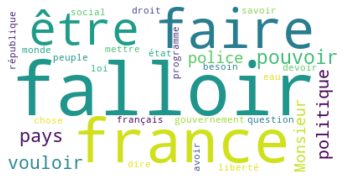

In [ ]:
# Wordcloud de Jean Luc Mélenchon

lemat_jlm = " ".join(df.loc[df.user_id=="JLMelenchon", "preprocessed_text"])
print("Wordcloud des mots lemmatisés de l'ensemble des tweets de Jean-Luc Mélenchon")
create_wordcloud(lemat_jlm, 30)

Wordcloud des mots lemmatisés de l'ensemble des tweets de Marine Le Pen


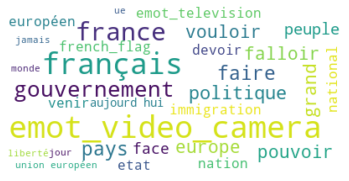

In [ ]:
# Wordcloud de Marie Le Pen

lemat_mlp = " ".join(df.loc[df.user_id=="MLP_officiel", "preprocessed_text"])
print("Wordcloud des mots lemmatisés de l'ensemble des tweets de Marine Le Pen")
create_wordcloud(lemat_mlp, 30)

## **4. Scattertext**

Comparaison visuelle du vocabulaire utilisé par MLP et JLM. 


In [ ]:
#objet corpus pour scattertext
corpus = st.CorpusFromPandas(data_frame = df.loc[df.user_id != "EmmanuelMacron"],
                             category_col = "user_id",
                             text_col = "preprocessed_text",
                             nlp = nlp).build().compact(st.AssociationCompactor(4000)) #On ne prend que les 4000 mots les plus importants dans le scattertext

In [ ]:
# On crée le html du scattertext
html = st.produce_scattertext_explorer(  corpus
                                       , category                  = 'JLMelenchon'
                                       , category_name             = 'Jean Luc Mélenchon'
                                       , not_category_name         = 'Marine Le Pen'
                                       , minimum_term_frequency    = 10
                                       , pmi_threshold_coefficient = 1
                                       , term_ranker               = st.AbsoluteFrequencyRanker
                                       , transform                 = st.Scalers.dense_rank
                                       , term_scorer               = st.RankDifference() 
#on peut égalemet tester le term_scorer ScaledFscore : st.ScaledFScorePresets(beta=1, one_to_neg_one=True)
                                       , width_in_pixels           = 1000
                                       )

# On enregistre le html
open("tweets_visualisation.html", 'wb').write(html.encode('utf-8'))

1390929